A notebook to calculate data for the Bayesian bot (analogous to training for ML bots)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
import ast
import json

In [18]:
# Loads M19 drafts
draftPath = "../../data/standardized_m19/drafts_train.pkl"
drafts = None
with open(draftPath, "rb") as f:
    drafts = pickle.load(f)

# Loads ratings
ratingPath = "../../data/standardized_m19/standardized_m19_rating.tsv"
nameList = pd.read_csv(ratingPath, delimiter="\t", converters={6:ast.literal_eval})
nameList['id'] = range(len(nameList))
nameList = nameList.set_index('Name')
nameList[1:5]

,Casting Cost 1,Casting Cost 2,Card Type,Rarity,Rating,Color Vector,id
Name,,,,,,,
Act_of_Treason,2R,none,Spell,C,2.0,"[0, 0, 0, 1, 0]",1
Aegis_of_the_Heavens,1W,none,Instant,U,1.9,"[1, 0, 0, 0, 0]",2
Aerial_Engineer,2UW,none,Creature,U,3.0,"[1, 1, 0, 0, 0]",3
Aether_Tunnel,1U,none,Spell,U,2.0,"[0, 1, 0, 0, 0]",4


### Calculate all the stats

In [35]:
nCardsInSet = len(nameList)
nCoDraft = np.zeros([nCardsInSet,nCardsInSet]) # Asymmetric co-draft matrix, numerator
dCoDraft = np.zeros([nCardsInSet,nCardsInSet]) # Denominator
nChoice = np.zeros([nCardsInSet,nCardsInSet])  # Asymmetric choice matrix, numerator
dChoice = np.zeros([nCardsInSet,nCardsInSet])  # Denominator
pFull = np.zeros(nCardsInSet) # Total number of times each card was drafted

In [40]:
# Main loop (very slow, unfortunately: 18 min for 5,000 drafts)

nameDict = {cardName: nameList.loc[cardName].id for cardName in nameList.index}
nDrafts = len(drafts)  # <----- Replace len(drafts) with 100 to troubleshoot on first 100 drafts
tic = time.time()
for iDraft in range(nDrafts): #range(len(drafts)):
    if iDraft % 10000 == 0:
        print("\nDraft #%d/%d" % (iDraft,nDrafts), end = '')
    if iDraft % 200 == 0:
        print('.', end = '')
    draft = drafts[iDraft]
    collection = np.zeros(nCardsInSet)
    for pack in draft:     
        packVector = np.zeros(nCardsInSet)
        pos = [nameDict[cardName] for cardName in pack]
        humanCard = pos[0]
        np.add.at(packVector,pos,1)

        humanPick = np.zeros(nCardsInSet)
        humanPick[humanCard] = 1
        
        # Preference matrix. A_ij counts how many times card i won over card j:
        nChoice += np.outer(humanPick,packVector)
        dChoice += np.outer(packVector,packVector)
        # Co-draft matrix, asymmetric. A_ij counts how many times i was drafted, with j already in collection:
        nCoDraft += np.outer(humanPick,collection)
        dCoDraft += np.outer(packVector,collection) # Denominator: how many times it could have been drafted
        
        collection[humanCard] += 1 # Update collection
        
    # -- Out of drafting: Final collection
    # Symmetric variant of co-draft matrix (assumed to be inferior than asymmetric, but not deleted for now)
    # A_ij counts how many times cards i and j were co-drafted (symmetric matrix)
    # pCoDraft += np.outer(collection,collection)-np.diag(collection) # Diagonal: n^2-n = n(n-1)
    
    pFull += collection

# -- Out of loop
print('\nDone. Time elapsed (minutes): %7.2f' % (float(time.time() - tic)/60))


Draft #0/86359..................................................
Draft #10000/86359..................................................
Draft #20000/86359..................................................
Draft #30000/86359..................................................
Draft #40000/86359..................................................
Draft #50000/86359..................................................
Draft #60000/86359..................................................
Draft #70000/86359..................................................
Draft #80000/86359................................Done. Time elapsed (minutes):   25.94


In [41]:
# --- Final adjustments to everything
# Set self-comparisons to zero for nChoice, as they don't matter:
np.fill_diagonal(nChoice,0) # Weird method that modifies its argument instead of returning something

# Probabilities from numbers:
pChoice = nChoice/np.maximum(1, dChoice)
pCoDraft = nCoDraft/np.maximum(1, dCoDraft)

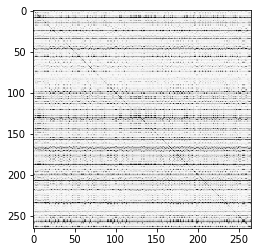

In [42]:
plt.imshow(pCoDraft, cmap="Greys");
# print(pCoDraft[0:6,0:6])

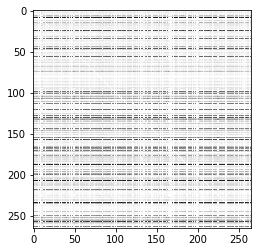

In [43]:
plt.imshow(pChoice, cmap="Greys");
# pChoice[0:5,0:5]

In [44]:
# pFull[1:19]

In [46]:
# --- Save everything
np.savetxt('bots_data/bayes_pCoDraft.csv', pCoDraft, delimiter=",")
np.savetxt('bots_data/bayes_pChoice.csv', pChoice, delimiter=",")
np.savetxt('bots_data/bayes_pFull.csv', pFull, delimiter=",")
np.savetxt('bots_data/nChoice.csv', nChoice, delimiter=",")
np.savetxt('bots_data/dChoice.csv', dChoice, delimiter=",")
np.savetxt('bots_data/nCoDraft.csv', nCoDraft, delimiter=",")
np.savetxt('bots_data/dCoDraft.csv', dCoDraft, delimiter=",")
# Save card names, to match later
pd.DataFrame(nameList.index).to_csv('bots_data/bayes_names.csv',index=False)

In [7]:
#nChoice = np.loadtxt('bots_data/nChoice.csv',  delimiter=",")
#dChoice = np.loadtxt('bots_data/dChoice.csv',  delimiter=",")
#nCoDraft = np.loadtxt('bots_data/nCoDraft.csv',  delimiter=",")
#dCoDraft = np.loadtxt('bots_data/dCoDraft.csv',  delimiter=",")